# Facebook Social Circles
Link: https://snap.stanford.edu/data/ego-Facebook.html

>This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.

---

Link prediction models operate on highly imbalanced datasets, where non-existent links far outnumber existing ones. Negative sampling addresses this by selecting a manageable and informative subset of non-existent links for training. This notebook explores two primary negative sampling approaches.

In [76]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Const
dataset = "data/facebook_combined.txt"
random.seed(42)

In [77]:
## Create Graph ##
G = nx.read_edgelist(dataset, nodetype=int)

print("Nodes:",len(list(G.nodes)))
print("Edges:",len(list(G.edges)))

Nodes: 4039
Edges: 88234


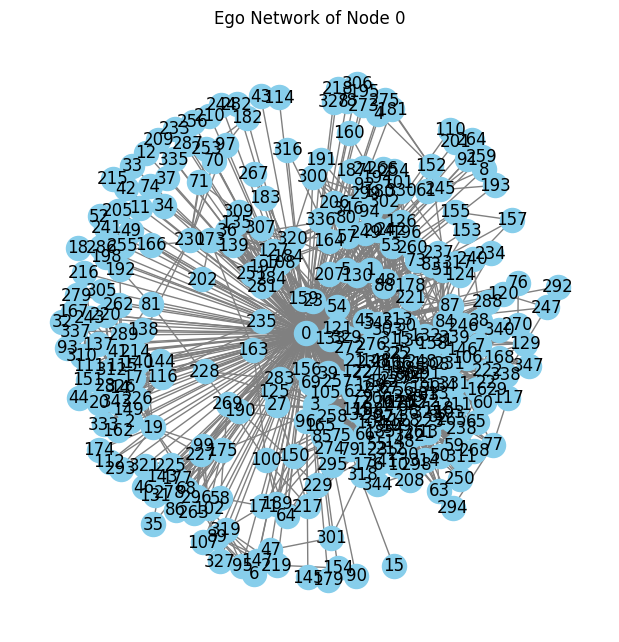

In [78]:
## Draw the graph ##
## The ego network allow to easily analyze and understand local network structure ##

ego = nx.ego_graph(G, 0) # Ego Network of node 0
pos = nx.spring_layout(ego, seed=42) # Spring layout for better visualization
plt.figure(figsize=(6, 6))
nx.draw(ego, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=300, )
plt.title("Ego Network of Node 0")
plt.show()

In [79]:
## Define features ##

def common_neighbors(u, v, G):
    return len(list(nx.common_neighbors(G, u, v)))

def build_feature_dataset(pairs, G):
    return [[common_neighbors(u, v, G)] for u, v in pairs]

In [80]:
def create_train_test_split(G, negative_sampling_fun, test_ratio=0.2):
    # Split Positive Edges
    edges = list(G.edges())
    random.shuffle(edges)
    split_idx = int((1 - test_ratio) * len(edges))
    train_edges = edges[:split_idx]
    test_edges = edges[split_idx:]

    # Create training graph
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    # Split Negative Edges
    negative_edges = negative_sampling_fun()
    negative_edges = list(negative_edges)
    random.shuffle(negative_edges)
    neg_train_edges = negative_edges[:split_idx]
    neg_test_edges = negative_edges[split_idx:]

    # Combined Positive + Negative (Train)
    X_train_pos = build_feature_dataset(train_edges, G_train)
    X_train_neg = build_feature_dataset(neg_train_edges, G_train)
    X_train = X_train_pos + X_train_neg
    y_train = np.concatenate([np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))])

    # Combined Positive + Negative (Test)
    X_test_pos = build_feature_dataset(test_edges, G_train)
    X_test_neg = build_feature_dataset(neg_test_edges, G_train)
    X_test = X_test_pos + X_test_neg
    y_test = np.concatenate([np.ones(len(X_test_pos)), np.zeros(len(X_test_neg))])

    return X_train, X_test, y_train, y_test


In [81]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    ## Train on Random Forest ##
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    ## Evaluate ##
    y_pred = clf.predict_proba(X_test)[:,1] # Returns 2D with 0 and 1 class probability pairs
    auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {auc:.4f}")

## 1. Random Negative Sampling
The initial negative sampling method explored is **random negative sampling**. This heuristic selects non-existent connections purely at random from all possible unobserved links.

- **Simplicity**: Easiest to implement, requiring only random node selection and non-existence checks.
- **Computational Efficiency**: Inexpensive, scaling well due to its random nature.
- **"Easy" Negatives**: Frequently generates negative examples (e.g., node pairs far apart or with zero common neighbors) that are trivial for a common-neighbor-based classifier to distinguish from positive links.

In [82]:
## Random Negative Sampling ##
# (O(negative_set_size))
def random_negative_sampling(positive_samples, num_nodes, negative_samples_ratio=1):
    positive_set = set(tuple(sorted(link)) for link in positive_samples) # Set for O(1) lookup

    negative_candidates = set()
    negative_set_size = len(positive_set) * negative_samples_ratio

    while len(negative_candidates) < negative_set_size: # O(n)
        u, v = random.sample(range(num_nodes), 2) # Should be O(1)
        pair = tuple(sorted((u, v)))

        if pair not in positive_set and pair not in negative_candidates:
            negative_candidates.add(pair)

    return negative_candidates

In [83]:
X_train, X_test, y_train, y_test = create_train_test_split(
    G,
    lambda: random_negative_sampling(list(G.edges()), len(list(G.nodes)))
)

train_and_evaluate(X_train, y_train, X_test, y_test)

ROC-AUC: 0.9907


A high ROC-AUC score with random negative sampling is often misleading. This result indicates the model is learning to solve an overly simple problem. Randomly selected negatives are frequently "easy" to distinguish from positive links, especially when using only common neighbors as a feature. This inflated performance highlights the necessity of a more challenging negative sampling strategy for realistic evaluation.

## Common-Neighbor Based Negative Sampling
Common-Neighbor Based Negative Sampling prioritizes non-existent links that share a relatively high number of common neighbors.

- **"Harder" Negatives**: Focuses on negative examples that are structurally similar to positive links based on common neighbors.
- **Realistic Problem**: Creates a more realistic evaluation scenario, forcing the model to learn subtle distinctions where common neighbors alone are insufficient.

In [84]:
## Common-Neighbors Negative Sampling ##
# A simpler implementation that takes just the top k node pairs with most common neighbors without a link between them.
# Should anyway lower the ROC-AUC score.
# O(n^2 * k) where n = number of nodes, k = average number of neighbors per node
def top_common_neighbors_negative_sampling(G, positive_samples, negative_samples_ratio=1):
    positive_set = set(tuple(sorted(link)) for link in positive_samples)

    non_edges_with_scores = []
    nodes = list(G.nodes())

    for i, u in enumerate(nodes): # Nested loops O(n^2)
        for v in nodes[i+1:]:
            pair = tuple(sorted((u, v)))

            if pair not in positive_set: # Count common neighbors O(k)
                u_neighbors = set(G.neighbors(u))
                v_neighbors = set(G.neighbors(v))
                common_neighbors = len(u_neighbors & v_neighbors)

                non_edges_with_scores.append((pair, common_neighbors))

    # Sort by common neighbors (descending) and take top-K
    non_edges_with_scores.sort(key=lambda x: x[1], reverse=True)
    negative_set_size = len(positive_set) * negative_samples_ratio

    top_pairs = non_edges_with_scores[:negative_set_size]
    return set(pair for pair, _ in top_pairs)

In [85]:
X_train, X_test, y_train, y_test = create_train_test_split(
    G,
    lambda: top_common_neighbors_negative_sampling(G, list(G.edges()), negative_samples_ratio=1)
)

train_and_evaluate(X_train, y_train, X_test, y_test)

ROC-AUC: 0.7448


The observed ROC-AUC score is a significantly more realistic performance indicator. This reduction from the random sampling score confirms the successful introduction of "harder" negative examples into both training and test sets. It is important to note that this implementation selects a simplified "top-k" set of negative pairs based on common neighbors. A more comprehensive or refined implementation of common-neighbor based negative sampling could potentially yield a different score.